In [1]:
import argparse
import logging
import pickle
from pathlib import Path

import pandas as pd

from digital_twin.models.norm_flow.model import NormFlowModel, DEFAULT_CHECKPOINTS_DIR
from digital_twin.models.density_estimation import GMM, Grouper, Regressor
from sklearn.model_selection import train_test_split
import torch
import random
import numpy as np
from glob import glob
import pandas as pd
import os, sys

from sklearn.metrics import make_scorer
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from digital_twin.performance_metrics import ape

In [2]:
dirpath = "dataset/"

data_files = ["cache/test_cache.csv", 
              "pools/test_ssd_random.csv", 
              "pools/test_ssd_sequential.csv", 
              "pools/test_hdd_sequential.csv"]

## NF model

In [3]:
def get_X_y(df):
    df[['r0', 'r1']] = df['raid'].str.split('+', n=1, expand=True)
    df.replace({'random': 0, 'sequential': 1, 'read': 0, 'write': 1}, inplace=True)
    return df.drop(["iops", "lat", "id", 'raid', 'device_type', 'offset'], axis=1), df[["iops", "lat"]]

In [4]:
def get_params(df):
    np.random.seed(1223)
    xx = df.sample()
    xx.reset_index(drop=True, inplace=True)
    sampled_params = xx.iloc[0].to_dict()
    return sampled_params

In [5]:
def plot_graphs(df_, cols_to_check):
    for col in cols_to_check:
        display(f'Now plotting the {col} values')
        start = df_[col].min()
        stop = df_[col].max()
        new_vals = np.arange(start, stop)
        sampled_params = get_params(df)
        metrics = []
        for val in new_vals:
            sampled_params[col] = val
            metric = model.sample(sampled_params, n_samples=100).mean(0)

            metrics.append(metric)        
        metrics = np.array(metrics).T
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

        # Plot the first histogram
        sns.histplot(x=new_vals, weights=metrics[0], bins=len(new_vals), kde=False, color='blue', ax=axes[0])
        axes[0].set_title(f'IOPS Over {col} distribution')
        axes[0].set_xlabel(f'{col} values')
        axes[0].set_ylabel('IOPS Distribution')
        axes[0].grid(False)

        # Plot the second histogram
        sns.histplot(x=new_vals, weights=metrics[1], bins=len(new_vals), kde=False, color='green', ax=axes[1])
        axes[1].set_title('Latency Distribution')
        axes[1].set_xlabel(f'{col} values')
        axes[1].set_ylabel('Latency Distribution')
        axes[1].grid(False)

        # Show the plots
        plt.tight_layout()
        plt.show()

In [6]:
def get_model(model_cls, data):
    t = data.split('/')
    t[1] = t[1].split('_')
    t[1][0] = 'nf_train'
    t[1][-1] = t[1][-1].split('.')[0]
    m_p = '_'.join(t[1])
    path = f'{t[0]}/{m_p}'
    ckpt_dir = f'models_checkpoints/{path}/'
    print(f'Reading the {ckpt_dir} checkpoint')
    model = model_cls.load(ckpt_dir)
    return model

Reading the cache/test_cache.csv data
Reading the models_checkpoints/cache/nf_train_cache/ checkpoint
Working with ['block_size', 'n_jobs', 'iodepth', 'read_fraction'] params


'Now plotting the block_size values'

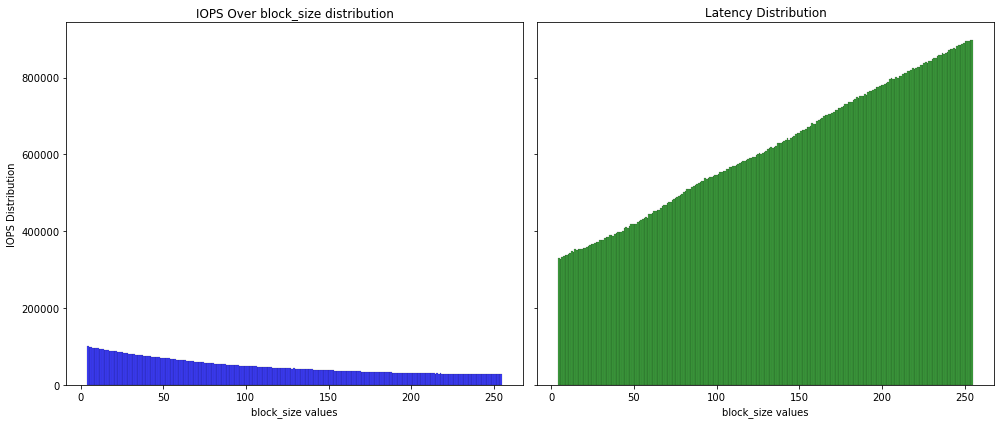

'Now plotting the n_jobs values'

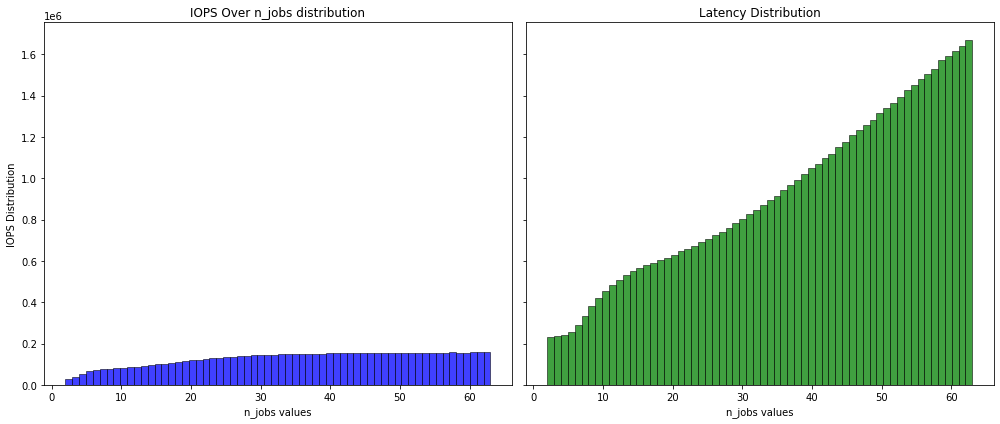

'Now plotting the iodepth values'

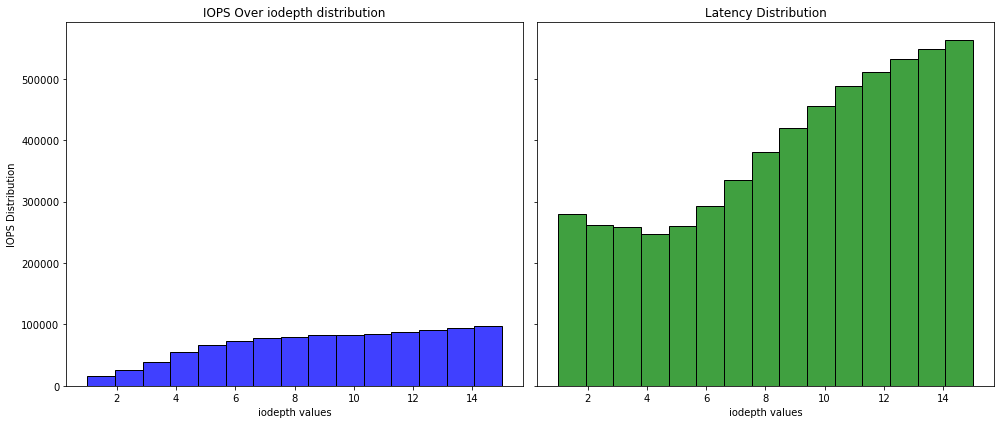

'Now plotting the read_fraction values'

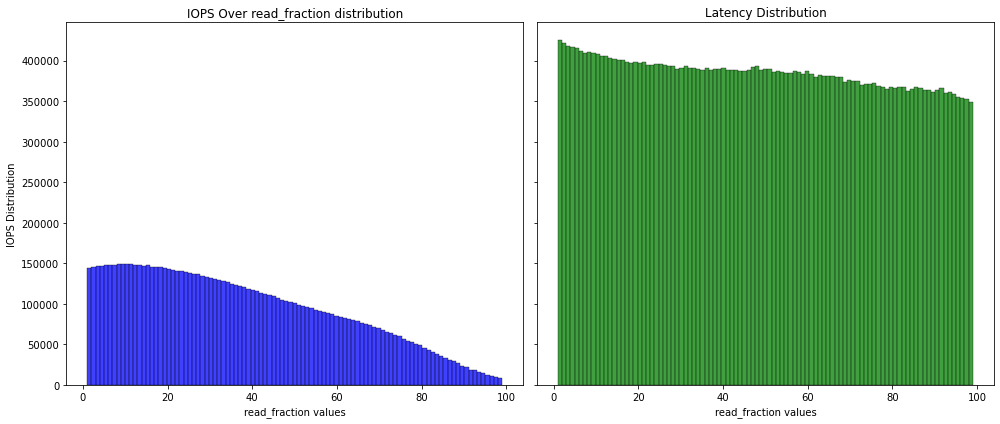

Reading the pools/test_ssd_random.csv data
Reading the models_checkpoints/pools/nf_train_ssd_random/ checkpoint
Working with ['n_jobs', 'iodepth', 'read_fraction', 'n_disks'] params


'Now plotting the n_jobs values'

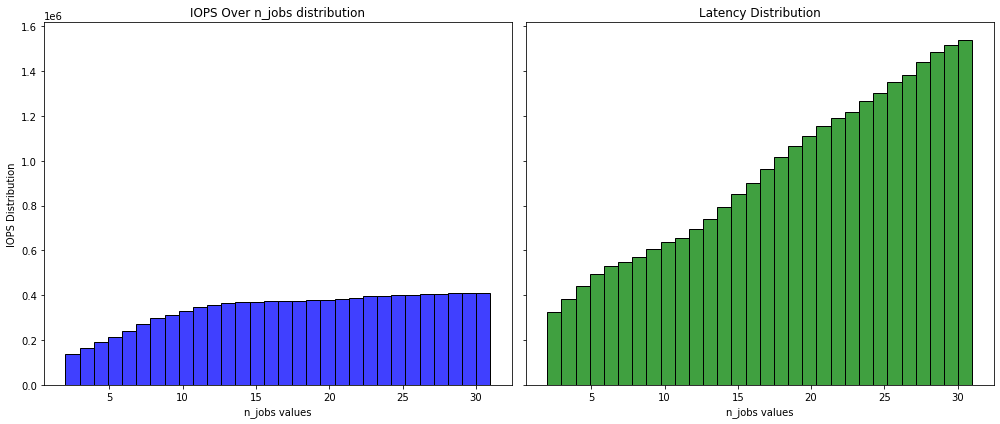

'Now plotting the iodepth values'

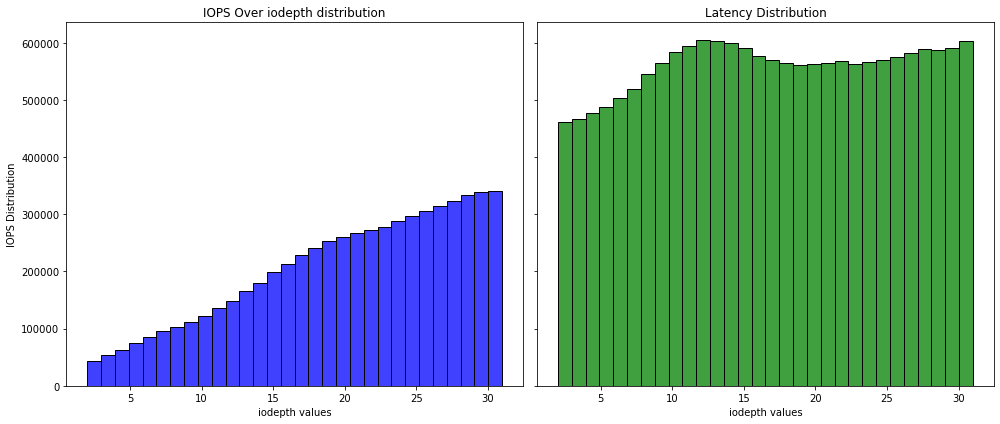

'Now plotting the read_fraction values'

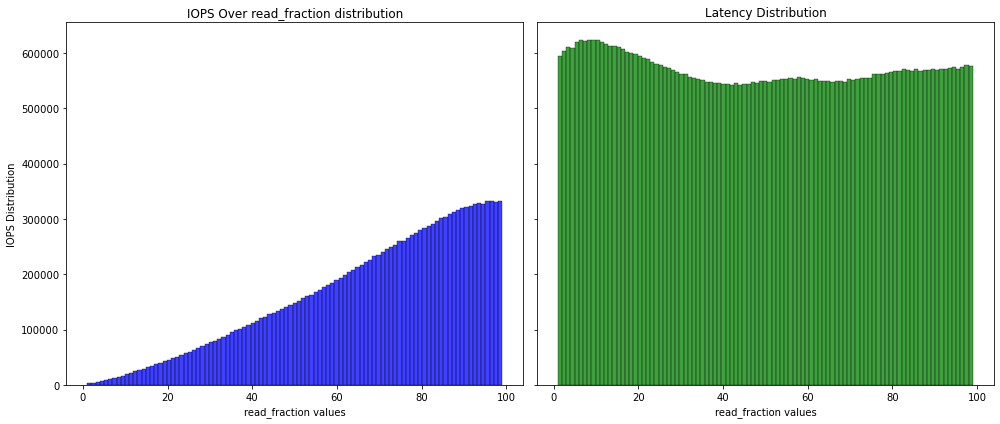

'Now plotting the n_disks values'

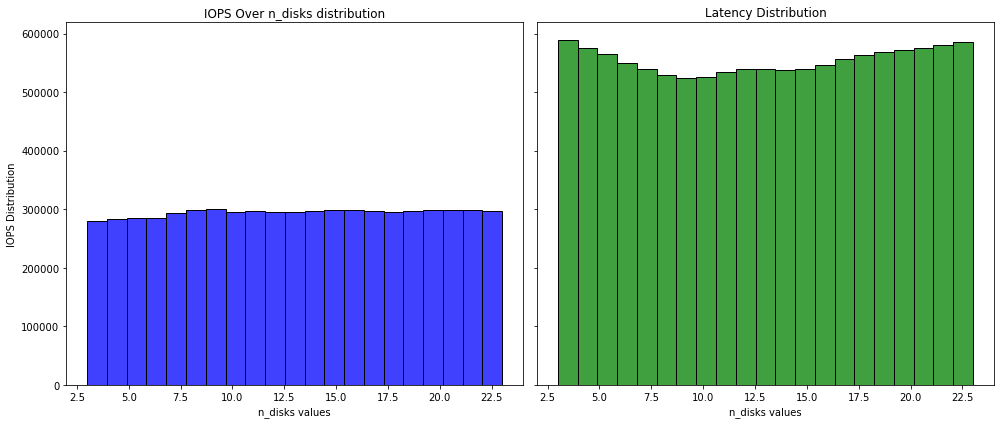

Reading the pools/test_ssd_sequential.csv data
Reading the models_checkpoints/pools/nf_train_ssd_sequential/ checkpoint
Working with ['n_jobs', 'iodepth', 'n_disks'] params


'Now plotting the n_jobs values'

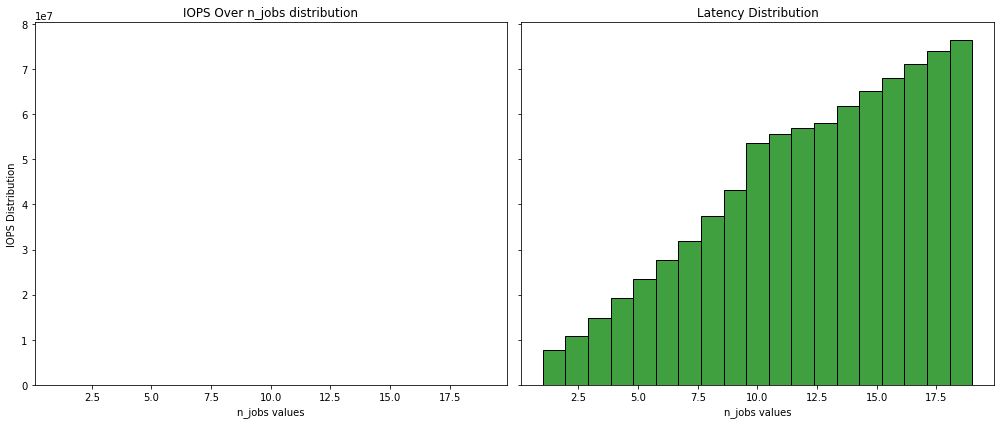

'Now plotting the iodepth values'

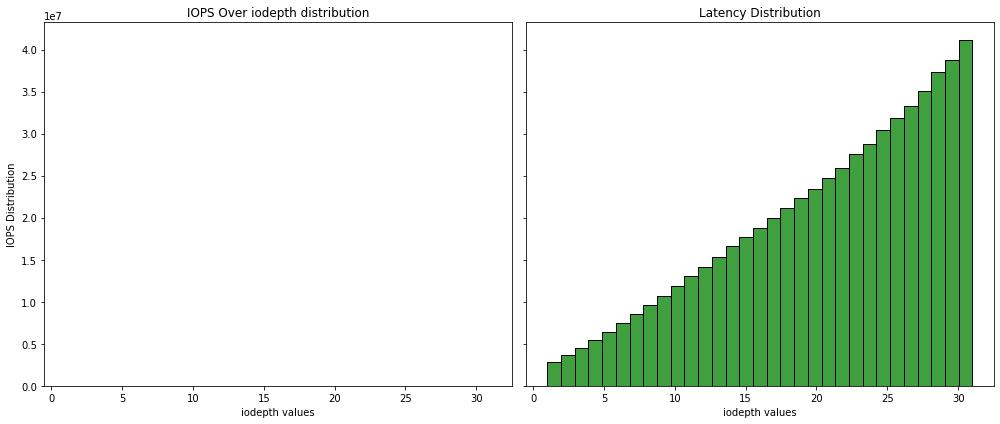

'Now plotting the n_disks values'

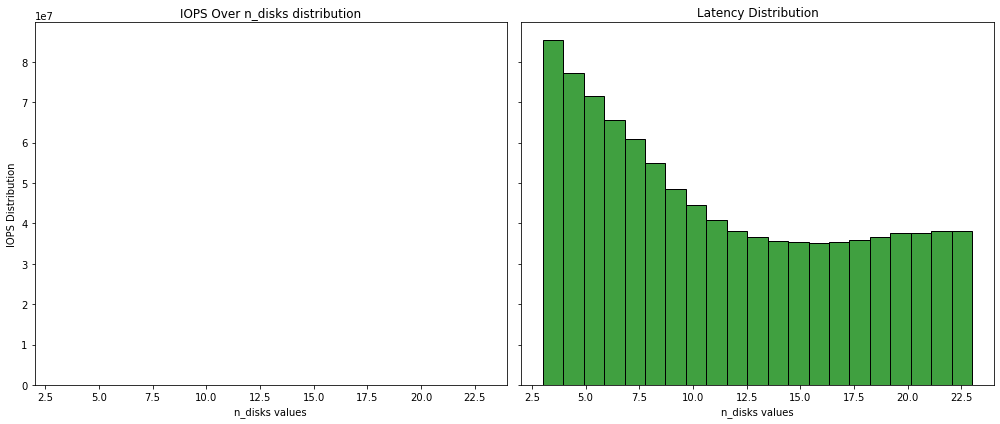

Reading the pools/test_hdd_sequential.csv data
Reading the models_checkpoints/pools/nf_train_hdd_sequential/ checkpoint
Working with ['n_jobs', 'iodepth', 'n_disks'] params


'Now plotting the n_jobs values'

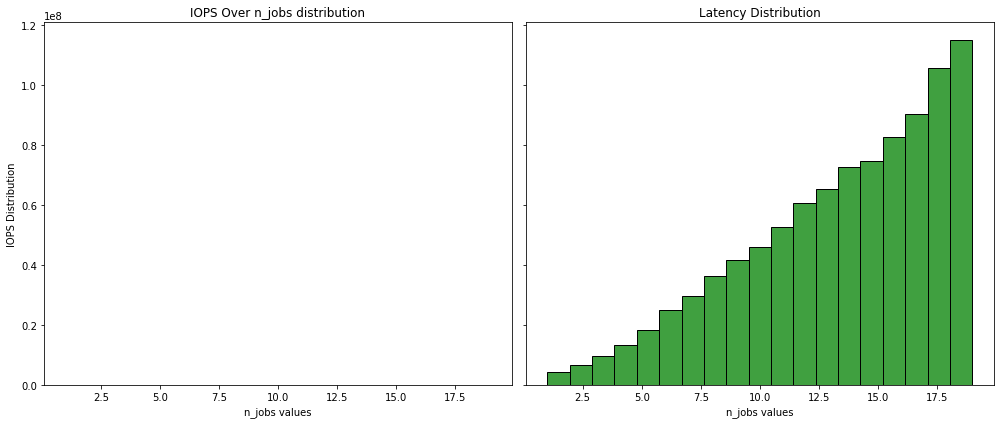

'Now plotting the iodepth values'

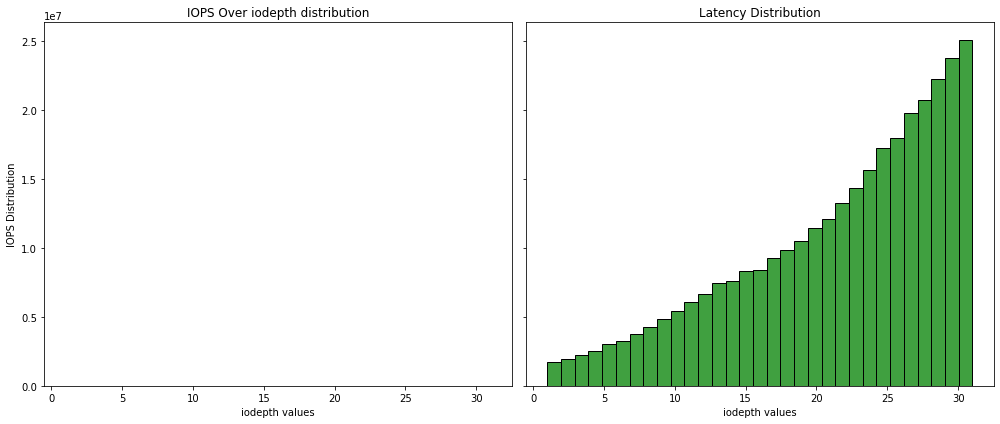

'Now plotting the n_disks values'

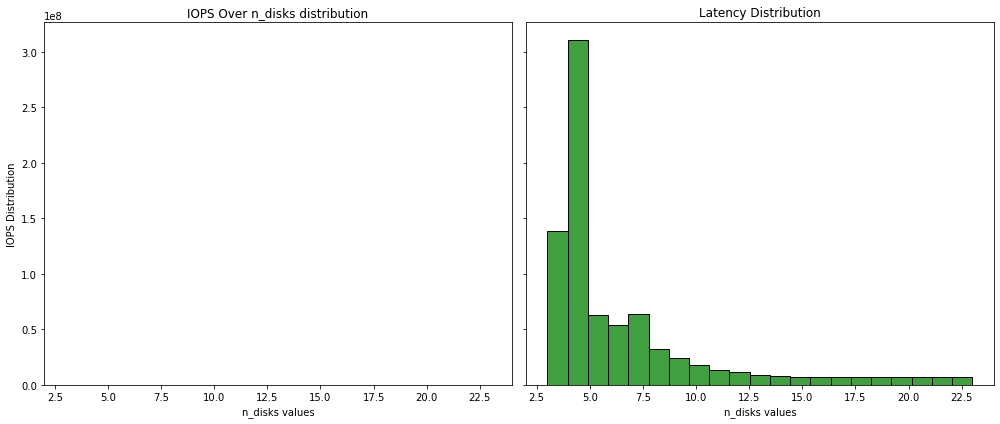

In [7]:
for adata in data_files:
    print(f'Reading the {adata} data')
    df = pd.read_csv(dirpath+adata)
    model = get_model(NormFlowModel, adata)
    X, _ = get_X_y(df)
    unique_values = X.apply(lambda x: x.unique())
    cols = [col for col in unique_values.index if len(unique_values[col]) > 5]
    
    print(f'Working with {cols} params')
    
    plot_graphs(X, cols)